In [1]:
%cd /content/mini/train

!unzip -qq "/content/mini/train/train.zip"

[Errno 2] No such file or directory: '/content/mini/train'
/content
unzip:  cannot find or open /content/mini/train/train.zip, /content/mini/train/train.zip.zip or /content/mini/train/train.zip.ZIP.


---

## 0. 환경 설정하기

### 1) 구글 드라이브 연결하기

In [2]:
# 코랩 사용 시 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2) 경로 확인하기
- "WORK_SPACE" 에 본인 작업 경로 작성 후 실행(구글 드라이브 최상위에 압축해제 시 그대로 실행. 수정 X).<br>

<font color="red">※ 주의. 나머지 경로는 절대 변경하지 마세요.</font>

In [3]:
# ROOT_PATH 확인 
import os

# 구글 드라이브 내 프로젝트 압축해제된 영역 (구글 드라이브 최상위에 압축해제 시 그대로 실행 수정 X)


if os.getcwd() == '/content' :
  # 구글 드라이브 사용 시 
  ROOT_PATH = '/content/drive/MyDrive/kt aivle/mini3_3일차'
else :
  ROOT_PATH = os.path.abspath('..')
# Train 데이터 셋 경로
TRAIN_PATH = ROOT_PATH + "/train"
# MODEL 저장 경로
MODEL_PATH = ROOT_PATH + "/model"

In [3]:
print(TRAIN_PATH)

/content/drive/MyDrive/kt aivle/mini3_3일차/train


### 3) 라이브러리 불러오기
필요시 추가 라이브러리는 설치해서 사용하세요.

In [4]:
# 필요 라이브러리 불러오기.
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Embedding
from keras.layers import Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.backend import clear_session

### 4) GPU 환경 확인하기
tensorflow가 GPU를 활용하고 있는지 확인하려면, tensorflow에서 제공하는 device_lib 라이브러리를 활용하면 됩니다.

In [ ]:
# GPU 환경 확인하기
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7103369379471590121
 xla_global_id: -1]

---

# 1. ImageDataGenerator 생성하기
앞의 <font color="red">__'[study] 2.데이터전처리'__ </font>과정에서 사용하였던 ImageDataGenerator를 그대로 가져오시면 됩니다.

<font color="green">[실습문제]</font> 1. ImageDataGenerator 생성하기
+ 모델 검증을 위해 데이터를 train:validation(8:2)로 분할합니다.
+ 모델 성능 개선을 위해 데이터 증식(Data augmentation)이 필요 시 자유롭게 설정

In [5]:
# 실습해보세요.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,  # 무작위 각도 범위 
    width_shift_range=0.3,   # 수평 이동 범위 비율  
    height_shift_range=0.3,  # 수직 이동 범위 비율
    shear_range=0.3,     # 층 밀리기 강도, 이미지 찌그리기
    zoom_range=0.3,     # 무작위 줌 범위  
    horizontal_flip=True,  # 가로로 뒤집음
    brightness_range=[0.7, 1.3],     # 이미지 밝기 
    # vertical_flip = True,    # 세로로 뒤집음 필요없을 듯 사람을 하다보니
    fill_mode='nearest',    # 변환된 이미지에서 생기는 빈 부분 채우는 방법
)
 
batch_size=32  
img_height = 415
img_width=854

# train_genrator 생성
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    batch_size=batch_size,
    target_size=(img_height, img_width),
    class_mode='categorical',
    subset='training',
    shuffle = True,
)

# validation_generator 생성
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    batch_size=batch_size,
    target_size=(img_height, img_width),
    subset='validation',
    class_mode='categorical',
    shuffle = False
)

Found 4828 images belonging to 4 classes.
Found 1205 images belonging to 4 classes.


In [ ]:
import matplotlib.pyplot as plt32
x_train, y_train = train_generator.next()
for idx in range(len(x_train)):  
    print(x_train[idx].shape)
    print(y_train[idx])
    plt.imshow(x_train[idx])
    plt.show()

In [6]:
print(train_generator.image_shape)
print(validation_generator.image_shape)

(415, 854, 1)
(415, 854, 1)


---

# 2. 모델 구성하기
+ KeyPoint : 합성곱 신경망 (CNN) 모델 구성.

<font color="green">[실습문제]</font> 2. CNN 모델을 설계해 보세요.
* 케라스를 이용해서 CNN 모델을 설계합니다.

In [11]:
clear_session()
model=Sequential()

model.add(Input(shape=(415,854,3)))
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
model.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 415, 854, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 415, 854, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 415, 854, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 415, 854, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 207, 427, 16)     0         
 )                                                               
                                                        

<font color="green">[실습문제]</font> 3. 모델을 학습시켜 보세요.
* 위에서 설계한 모델에 데이터를 가지고 학습을 진행 합니다. 
* history 변수에 학습 결과를 입력 받습니다.
* callback 함수로 ModelCheckpoint와 EarlyStopping을 사용하세요.(best만 저장)
* 학습한 모델의 weight를 경로 MODEL_PATH 에 저장해주세요.
* val_loss 기준으로 모니터링 해주세요.

In [7]:
# early_stopping 
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/kt aivle/mini3_3일차/model/model.ckpt',
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True,
                      save_weights_only=False
)
  

# early_stopping
early_stopping = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   restore_best_weights=True
)

In [12]:
2# 모델 학습
history = model.fit_generator(train_generator, validation_data=validation_generator
          ,epochs=10, verbose=1, callbacks=[early_stopping, checkpoint])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
76/76 [==============================] - ETA: 0s - loss: 0.8709 - accuracy: 0.6705 
Epoch 1: val_loss improved from inf to 15.98068, saving model to /content/drive/MyDrive/kt aivle/mini3_3일차/model/model.ckpt
76/76 [==============================] - 1748s 23s/step - loss: 0.8709 - accuracy: 0.6705 - val_loss: 15.9807 - val_accuracy: 0.3178
Epoch 2/10
76/76 [==============================] - ETA: 0s - loss: 0.6890 - accuracy: 0.7430
Epoch 2: val_loss improved from 15.98068 to 14.18522, saving model to /content/drive/MyDrive/kt aivle/mini3_3일차/model/model.ckpt
76/76 [==============================] - 486s 6s/step - loss: 0.6890 - accuracy: 0.7430 - val_loss: 14.1852 - val_accuracy: 0.1900
Epoch 3/10
76/76 [==============================] - ETA: 0s - loss: 0.6451 - accuracy: 0.7502
Epoch 3: val_loss did not improve from 14.18522
76/76 [==============================] - 477s 6s/step - loss: 0.6451 - accuracy: 0.7502 - val_loss: 25.0727 - val_accuracy: 0.2506
Epoch 4/10
76/76 [===

<font color="green">[실습문제]</font> 4. 모델 저장하기 
* 만들어진 모델를 기반으로 모델파일로 저장해주세요.
* 파일 저장 전에 ModelCheckpoint의 가중치(weights)를 로딩해주세요.
* 저장위치는 MODEL_PATH 입니다.
* 파일명은 <font color="red">[개인] 미니프로젝트3차_A000000_OOO.h5</font>

><font color="red">[Hint]</font><br>
>모델 가중치는 load_weight 매소드로 불러옵니다.<br>
>모델 저장시에는 model.save 매소드를 사용합니다. 

In [ ]:
from google.colab import files
files.download('[개인]미니프로젝트3차_A023123_이시영.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# 실습해보세요.
from keras.models import load_model

model.save('model3.h5')





In [ ]:
from keras.models import load_model
model = load_model('[개인]미니프로젝트3차_A023123_이시영.h5')

---

# 3. 모델 평가하기

<font color="green">[실습문제]</font> 5. 훈련 과정에서 epoch에 따른 정확도와 손실을 시각화화여 확인합니다.

In [11]:
# 실습해보세요.
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history['accuracy'][-1])
print(history.history['val_accuracy'][-1])
print(history.history['loss'][-1])
print(history.history['val_loss'][-1])




0.7976387739181519
0.7427386045455933
0.5284020304679871
0.6573324799537659


<font color="green">[실습문제]</font> 6. validation 데이터를 기준으로 학습한 모델을 적용해서 f1 Score를 계산하세요.

* <font color="red">hint.</font> sklearn.metrics 패키지에서 f1_score를 사용하세요.

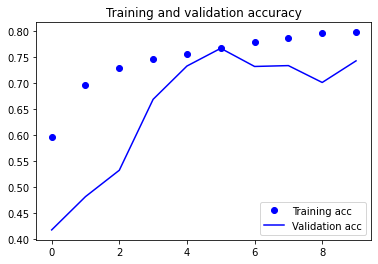

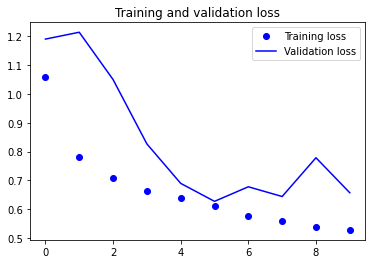

In [12]:
# 실습해보세요.
from sklearn.metrics import f1_score
import tensorflow as tf
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

---

## [추가학습] 모델 비교하기 
_시간이 남으면 해보세요._

<font color="green">[실습문제]</font> 7. 모델 구조를 변경해 보거나 다른 모델들을 만들어 보고 성능을 비교해 최고의 모델을 만들어 보세요.
- 여러분들이 배운 모델들을 다양하게 만들어 보고 성능을 비교해 보세요.
- ImageDataGenerator를 변경하면 성능 개선도 가능합니다. 

In [ ]:
# 실습해보세요.





